# Spatial Relationships between LR Pairs and cell Types using MISTy 

### Import packages

In [1]:
import scanpy as sc
import decoupler as dc
import plotnine as p9
import liana as li
import os

datadir = '../../datasets/Hands_on_2_LIANA_MistY/'

### Import functions needed for running MISTy 

In [2]:
from liana.method import MistyData, genericMistyData
from liana.method.sp import RandomForestModel, LinearModel, RobustLinearModel

### Load and Normalize Data

In [3]:
adata = sc.read(os.path.join(datadir, "kuppe_heart19.h5ad"))

In [4]:
adata.layers['counts'] = adata.X.copy()
sc.pp.normalize_total(adata, target_sum=1e4)
sc.pp.log1p(adata)

In [5]:
# Rename to more informative names
full_names = {'Adipo': 'Adipocytes',
              'CM': 'Cardiomyocytes',
              'Endo': 'Endothelial',
              'Fib': 'Fibroblasts',
              'PC': 'Pericytes',
              'prolif': 'Proliferating',
              'vSMCs': 'Vascular_SMCs',
              }
# but only for the ones that are in the data
adata.obsm['compositions'].columns = [full_names.get(c, c) for c in adata.obsm['compositions'].columns]

In [6]:
##### Extract Cell type Composition
comps = li.ut.obsm_to_adata(adata, 'compositions')

In [7]:
comps

AnnData object with n_obs × n_vars = 4113 × 11
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    uns: 'spatial', 'log1p'
    obsm: 'compositions', 'mt', 'spatial'

In [8]:
##### Compute Spatial Neighbors
li.ut.spatial_neighbors(adata, bandwidth=150, cutoff=0.1, kernel='gaussian', set_diag=True)

2025-10-31 15:46:48 | [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


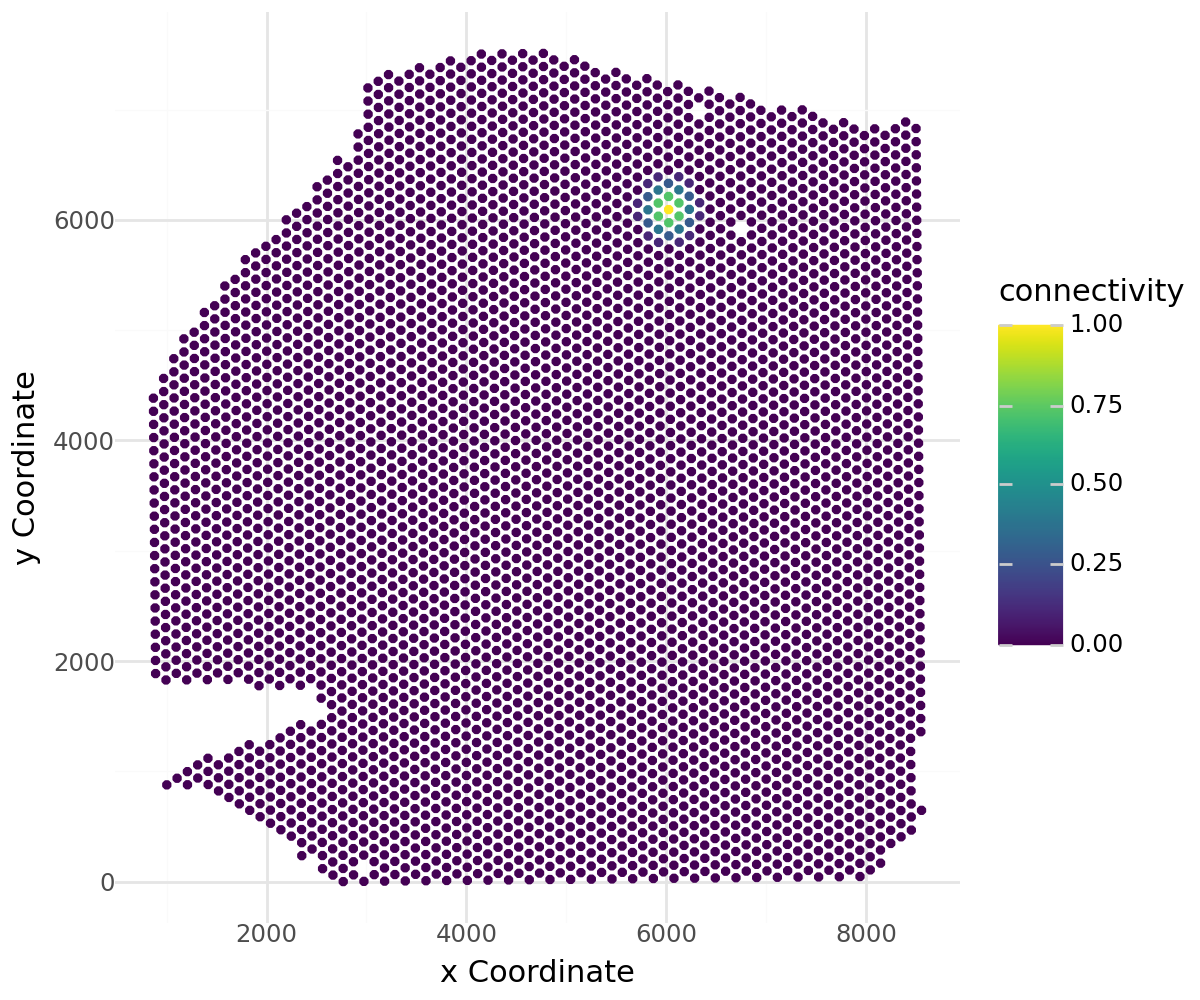

In [9]:
li.pl.connectivity(adata, idx=0, figure_size=(6,5))

In [10]:
# Compute LIANA's bivariate local spatial functions
lrdata = li.mt.bivariate(adata,
                resource_name='consensus', # uses HUMAN gene symbols
                local_name='cosine', # Name of the local function
                global_name="morans", # Name global function (or 'lee')
                n_perms=None, # Number of permutations to calculate a p-value
                mask_negatives=False, # Whether to mask LowLow/NegativeNegative interactions
                add_categories=True, # Whether to add local categories to the results
                nz_prop=0.3, # Minimum expr. proportion for ligands/receptors and their subunits
                use_raw=False,
                verbose=True
                )

2025-10-31 15:46:49 | [INFO] Using `.X`!
/opt/conda/lib/python3.11/site-packages/anndata/_core/anndata.py:381: FutureWarning: The dtype argument is deprecated and will be removed in late 2024.
2025-10-31 15:46:49 | [INFO] Using resource `consensus`.


In [11]:
# or load the lrdata
lrdata = sc.read("lrdata.h5ad")

In [12]:
lrdata

AnnData object with n_obs × n_vars = 4113 × 472
    obs: 'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
    var: 'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'mean', 'std'
    uns: 'log1p', 'spatial'
    obsm: 'compositions', 'mt', 'spatial'
    layers: 'cats'
    obsp: 'spatial_connectivities'

In [13]:
# # select the top 200 lr pairs based on mean
# top_vars = lrdata.var.sort_values("mean", ascending=False).head(300).index
# lrdata_top = lrdata[:, top_vars].copy()

In [14]:
# you can change the connectivity 
# li.ut.spatial_neighbors(lrdata, bandwidth=500, cutoff=0.1, kernel='gaussian', set_diag=True)
# li.pl.connectivity(lrdata, idx=0, figure_size=(6,5))

In [15]:
misty = MistyData(data={"intra": comps, "lrs": lrdata})

/opt/conda/lib/python3.11/site-packages/mudata/_core/mudata.py:1598: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.
/opt/conda/lib/python3.11/site-packages/mudata/_core/mudata.py:1461: FutureWarning: From 0.4 .update() will not pull obs/var columns from individual modalities by default anymore. Set mudata.set_options(pull_on_update=False) to adopt the new behaviour, which will become the default. Use new pull_obs/pull_var and push_obs/push_var methods for more flexibility.


In [16]:
misty

MuData object with n_obs × n_vars = 4113 × 483
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  2 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'spatial', 'log1p'
      obsm:	'compositions', 'mt', 'spatial'
    lrs:	4113 x 472
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      var:	'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'mean', 'std'
      uns:	'log1p', 'spatial'
      obsm:	'compositions', 'mt', 'spatial'
      layers:	'cats', 'weighted'
      obsp:	'spatial_connectivities'

## Learn Relationships with MISTy

This takes a while for, so you can instead just load the precomputed results. 
This code was used: 
```python
misty(model=LinearModel, n_jobs=-1, verbose = True, bypass_intra=True)
misty.write_h5mu('misty_mudata.h5mu'))
```

In [34]:
import muon as mu
misty = mu.read_h5mu(os.path.join(datadir, 'misty_mudata.h5mu'))
misty

MuData object with n_obs × n_vars = 4113 × 483
  obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
  uns:	'interactions', 'target_metrics'
  2 modalities
    intra:	4113 x 11
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      uns:	'log1p', 'spatial'
      obsm:	'compositions', 'mt', 'spatial'
    lrs:	4113 x 472
      obs:	'in_tissue', 'array_row', 'array_col', 'sample', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'mt_frac', 'celltype_niche', 'molecular_niche'
      var:	'ligand', 'receptor', 'ligand_means', 'ligand_props', 'receptor_means', 'receptor_props', 'morans', 'mean', 'std'
      uns:	'log1p', 'spatial'
      obsm:	'compositions', 'mt', 'spatial'
      layers:	'cats', 'weighted'
      obsp:	'spatial_connectivities'

In [35]:
misty.uns['target_metrics'].head()

,target,intra_R2,multi_R2,gain_R2,lrs
0,Adipocytes,0,0.238078,0.238078,1.0
1,Cardiomyocytes,0,0.649515,0.649515,1.0
2,Endothelial,0,0.219814,0.219814,1.0
3,Fibroblasts,0,0.508712,0.508712,1.0
4,Lymphoid,0,0.079976,0.079976,1.0


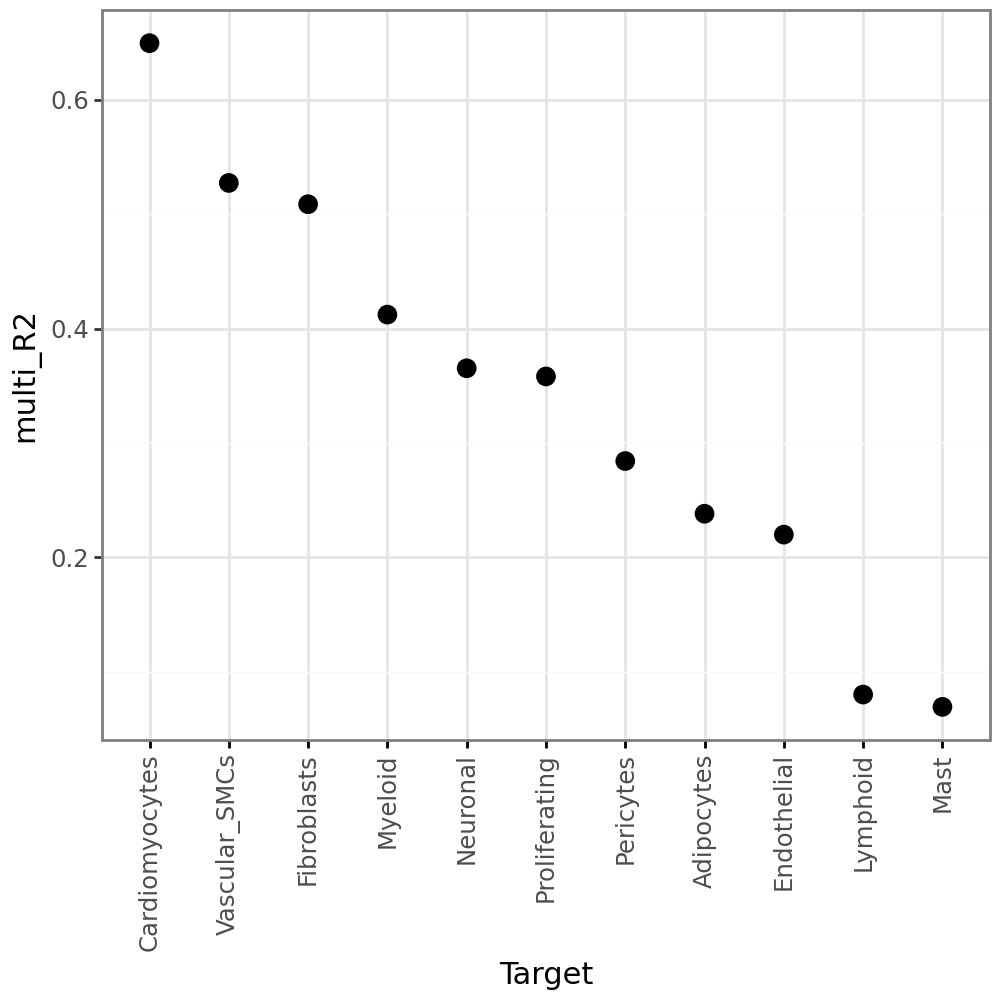

In [36]:
li.pl.target_metrics(misty, stat='multi_R2', return_fig=True)

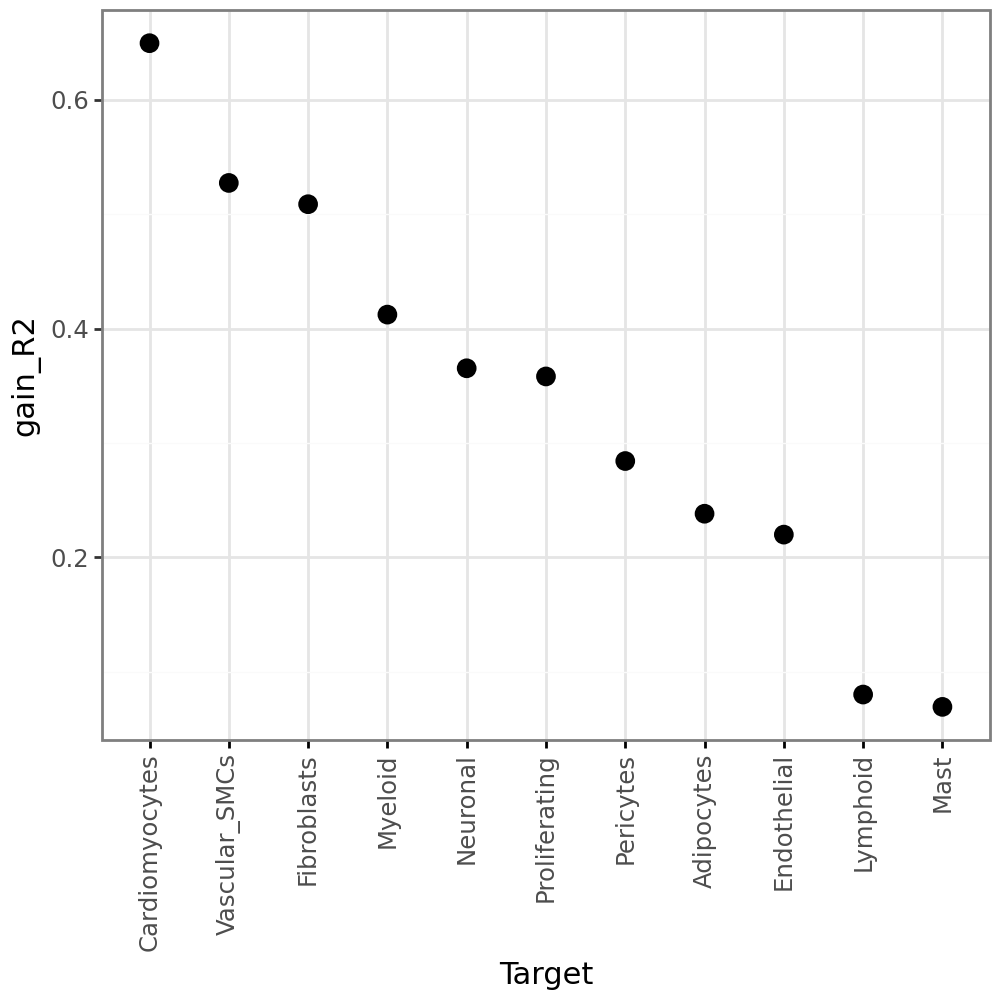

In [37]:
li.pl.target_metrics(misty, stat='gain_R2')

Finally, using the information above we know which variables are best explained by our model, and we know which view explains them best. 
So, we can now also see what are the specific variables that explain each target best:

In [38]:
misty.uns['interactions'].sort_values("importances", ascending=False).head(10)

,target,predictor,view,importances
4551,Proliferating,MMRN2^CD248,lrs,5.663353
5120,Vascular_SMCs,CALM3^INSR,lrs,5.662475
4798,Vascular_SMCs,COL1A1^ITGA3_ITGB1,lrs,4.749294
4820,Vascular_SMCs,FN1^SDC2,lrs,4.568264
4352,Proliferating,VTN^ITGAV_ITGB5,lrs,4.381104
843,Cardiomyocytes,LRPAP1^SORT1,lrs,4.327943
4660,Proliferating,ADAM10^GPNMB,lrs,4.298003
853,Cardiomyocytes,MDK^SDC4,lrs,4.297020
3675,Neuronal,LRPAP1^SORT1,lrs,4.287544
5168,Vascular_SMCs,CCN1^CAV1,lrs,4.238077


2025-10-31 16:21:34 | [INFO] Fontsize 0.00 < 1.0 pt not allowed by FreeType. Setting fontsize = 1 pt


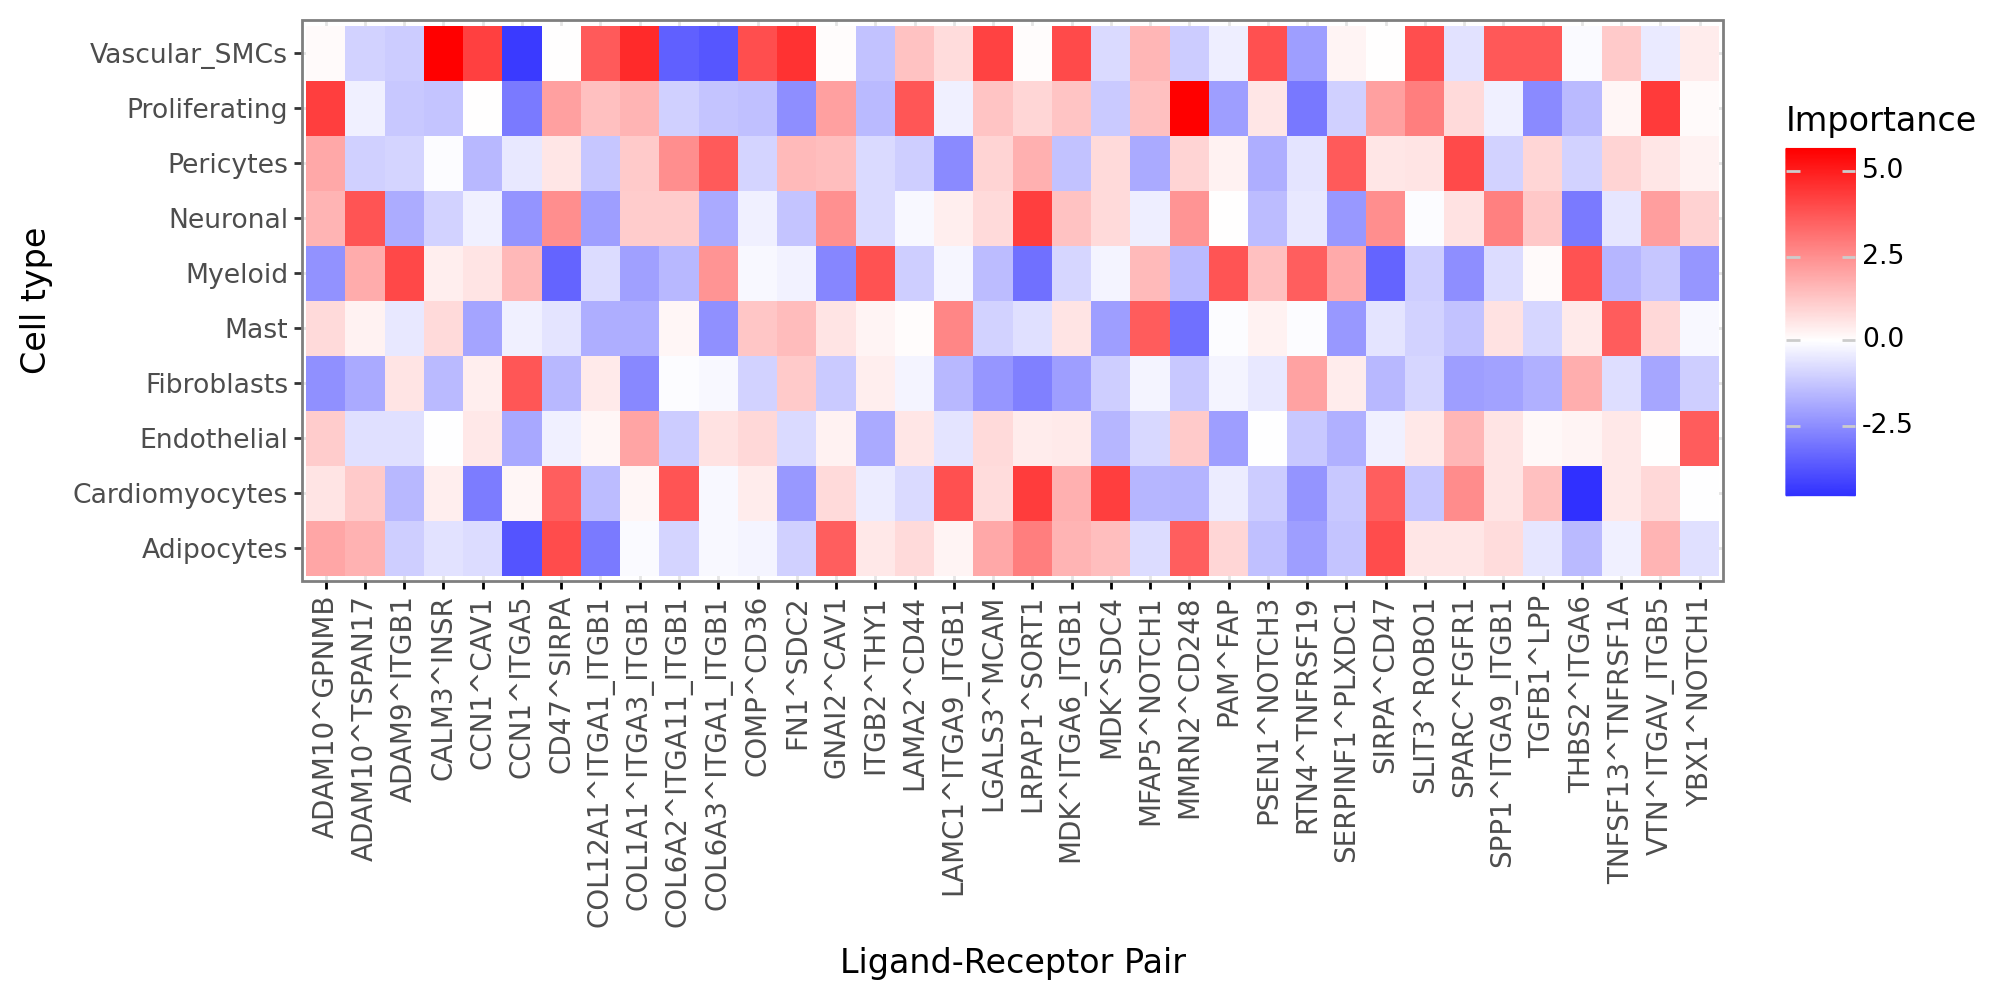

In [39]:
(
    li.pl.interactions(misty, view='lrs', top_n=40) + 
    p9.labs(x='Ligand-Receptor Pair', y='Cell type') +
    p9.theme_bw(base_size=12) +
    p9.theme(axis_text_x=p9.element_text(rotation=90, size=10)) +
    # change to blue-red
    p9.scale_fill_gradient2(low='blue', mid='white', high='red')+
    p9.theme(figure_size=(10, 5)) 
)

/tmp/ipykernel_110804/2569456449.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.


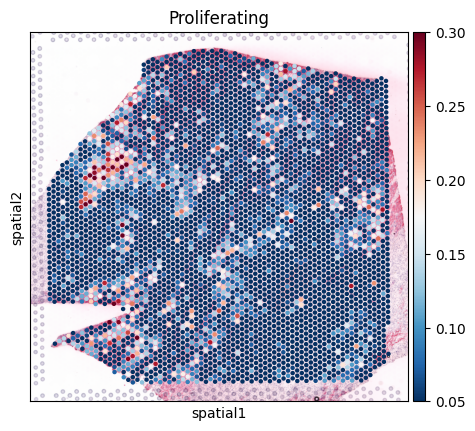

In [40]:
sc.pl.spatial(comps,  
              color=['Proliferating'], 
              cmap='RdBu_r', 
              size=1.3,
              vmin = 0.05, vmax = 0.3)


/tmp/ipykernel_110804/2282257081.py:1: FutureWarning: Use `squidpy.pl.spatial_scatter` instead.


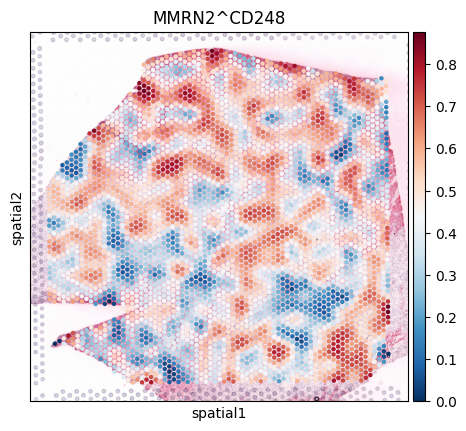

In [41]:
sc.pl.spatial(lrdata, color=['MMRN2^CD248'],  cmap='RdBu_r', size=1.3)